# Etapa 4: Modelo de preedicción

In [ ]:
# Montamos la unidad de Google Drive.
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/TFM

Mounted at /content/drive
/content/drive/MyDrive/TFM


In [ ]:
!pip install pycox
!pip install torchtuples
!pip install shap

In [ ]:
# Importamos módulos necesarios.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import torch
import torch.nn as nn

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import torchtuples as tt

import joblib

import shap

from utils import read_data, save_data

# Aplicamos configuración sobre la visualización de los DataFrames.
pd.set_option('future.no_silent_downcasting', True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set_theme()

# Ruta de los archivos de origen.
input_path = 'data/processed/'

In [ ]:
prediction = read_data(f'{input_path}prediction.csv')

In [ ]:
prediction.head()

,Age,Overall Survival,Vital Status,Estadio I,G1,R0,Cabeza,Metástasis hígado,KRAS,TP53,CDKN2A,SMAD4
0,68,431,1,0,0,0,1,0,1,1,0,0
1,56,277,1,0,0,1,1,1,1,1,0,0
2,50,920,1,0,0,0,1,0,1,1,0,1
3,66,1021,1,1,0,1,0,0,1,1,1,1
4,71,485,1,0,0,1,1,0,0,0,0,0
5,75,532,1,0,0,0,0,0,1,1,0,1
6,58,416,1,0,0,1,1,0,0,0,0,0
7,49,1116,1,0,0,0,0,0,1,1,0,0
8,63,230,1,0,0,1,1,0,1,0,0,0
9,82,292,1,0,0,1,1,0,1,1,0,0


In [ ]:
x = prediction.drop(['Overall Survival', 'Vital Status'], axis=1)
t = prediction['Overall Survival'].values.astype('float32')
e = prediction['Vital Status'].values.astype('float32')

In [ ]:
class SurvivalNet(nn.Module):
    def __init__(self, in_features):
        super(SurvivalNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_indexes = []
best_c_index = -1

for fold, (train_idx, val_idx) in enumerate(kf.split(x)):
    print(f"--- Entrenando Fold {fold+1} ---")

    x_train_fold, x_val_fold = x.iloc[train_idx].copy(), x.iloc[val_idx].copy()
    t_train, t_val = t[train_idx], t[val_idx]
    e_train, e_val = e[train_idx], e[val_idx]

    scaler = StandardScaler()
    x_train_fold['Age'] = scaler.fit_transform(x_train_fold[['Age']])
    x_val_fold['Age'] = scaler.transform(x_val_fold[['Age']])

    x_train = x_train_fold.values.astype('float32')
    x_val = x_val_fold.values.astype('float32')

    net = SurvivalNet(x_train.shape[1])
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.04)
    model = CoxPH(net, optimizer)

    callbacks = [tt.callbacks.EarlyStopping(patience=15)]
    val_data = (x_val, (t_val, e_val))

    model.fit(x_train, (t_train, e_train),
              batch_size=32,
              epochs=100,
              callbacks=callbacks,
              verbose=False,
              val_data=val_data)

    model.compute_baseline_hazards()

    surv = model.predict_surv_df(x_val)
    ev = EvalSurv(surv, t_val, e_val, censor_surv='km')
    c_index = ev.concordance_td()
    c_indexes.append(c_index)
    print(f"C-Index Fold {fold+1}: {c_index:.4f}")

    if c_index > best_c_index:
        best_c_index = c_index
        joblib.dump(scaler, 'model/scaler_final.pkl')
        torch.save(net.state_dict(), 'model/mejor_modelo_supervivencia.pt')
        print(f"Nuevo mejor modelo encontrado y guardado (C-Index: {best_c_index:.4f})")

print("-" * 30)
print(f"C-Index promedio final: {np.mean(c_indexes):.4f}")


modelo_final = SurvivalNet(in_features=x.shape[1])
modelo_final.load_state_dict(torch.load('model/mejor_modelo_supervivencia.pt'))
modelo_final.eval()
print("Modelo cargado")

--- Entrenando Fold 1 ---
C-Index Fold 1: 0.6766
Nuevo mejor modelo encontrado y guardado (C-Index: 0.6766)
--- Entrenando Fold 2 ---
C-Index Fold 2: 0.7218
Nuevo mejor modelo encontrado y guardado (C-Index: 0.7218)
--- Entrenando Fold 3 ---
C-Index Fold 3: 0.3742
--- Entrenando Fold 4 ---
C-Index Fold 4: 0.5070
--- Entrenando Fold 5 ---
C-Index Fold 5: 0.5068
------------------------------
C-Index promedio final: 0.5573
Modelo cargado


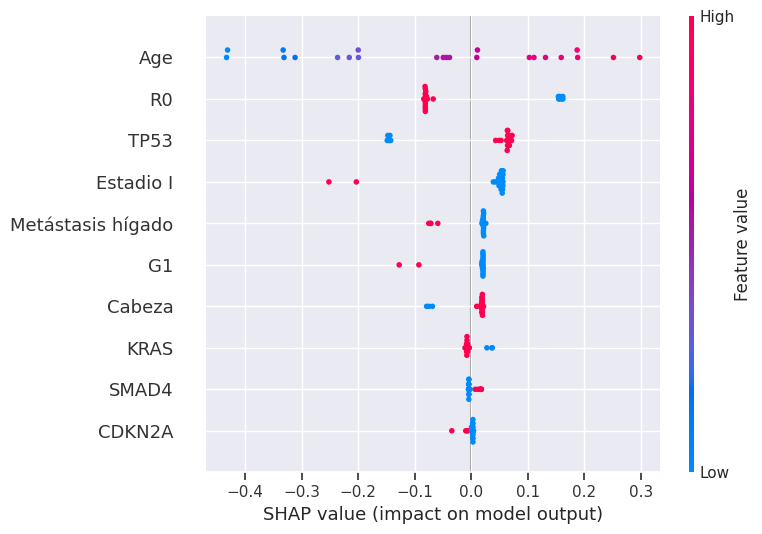

In [ ]:
def predict_risk(data_numpy):
    model.net.eval()
    data_tensor = torch.from_numpy(data_numpy).float()
    with torch.no_grad():
        return model.net(data_tensor).cpu().numpy().flatten()

explainer = shap.Explainer(predict_risk, x_train)

shap_values = explainer(x_val)

shap.summary_plot(shap_values, x_val, feature_names=x.columns)

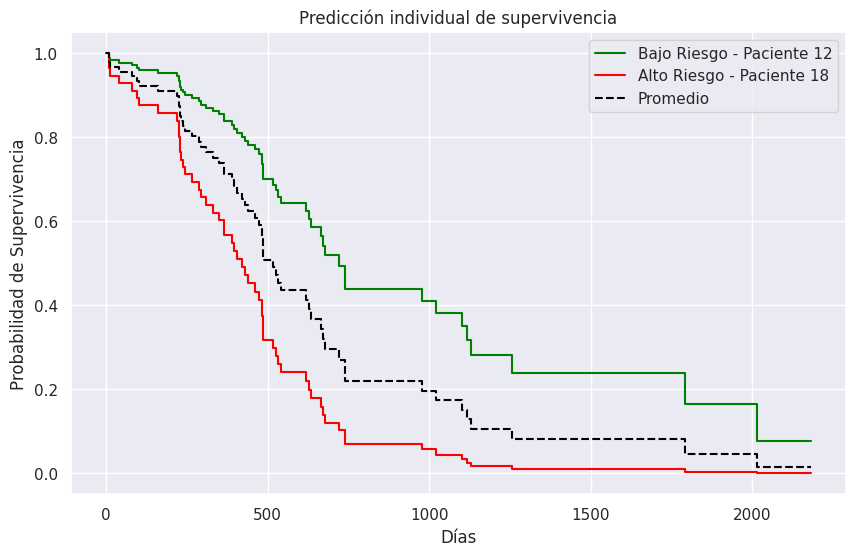

In [ ]:
risk_scores = model.predict(x_val)
idx_min = np.argmin(risk_scores)
idx_max = np.argmax(risk_scores)

surv_curves = model.predict_surv_df(x_val)

plt.figure(figsize=(10, 6))

plt.step(surv_curves.index, surv_curves.iloc[:, idx_min], label=f'Bajo Riesgo - Paciente {idx_min}', color='green')
plt.step(surv_curves.index, surv_curves.iloc[:, idx_max], label=f'Alto Riesgo - Paciente {idx_max}', color='red')

plt.step(surv_curves.index, surv_curves.mean(axis=1), label='Promedio', color='black', linestyle='--')

plt.ylabel("Probabilidad de Supervivencia")
plt.xlabel("Días")
plt.title("Predicción individual de supervivencia")
plt.legend()
plt.show()